<a href="https://colab.research.google.com/github/institutohumai/cursos-python/blob/master/CV/4_Transfer_Learning/3_TransferenciaEstilos.ipynb"> <img src='https://colab.research.google.com/assets/colab-badge.svg' /> </a>

# Transferencia de Estilos

Si es un entusiasta de la fotografía, es posible que esté familiarizado con los filtros. Los filtros pueden cambiar el estilo de color de las fotos para que las fotos de paisajes se vuelvan más nítidas o las fotos de retratos tengan pieles más blancas. Sin embargo, un filtro generalmente solo cambia un aspecto de la foto. Para aplicar un estilo ideal a una foto, probablemente necesite probar muchas combinaciones de filtros diferentes. Este proceso es tan complejo como ajustar los hiperparámetros de un modelo.

En esta clase, aprovecharemos las representaciones por capas de una CNN para aplicar automáticamente el estilo de una imagen a otra imagen, es decir, haremos **transferencias de estilos**. 

Esta tarea necesita dos imágenes de entrada: una es la **imagen de contenido** y la otra es la **imagen de estilo**. Usaremos redes neuronales para modificar la imagen del contenido para que su estilo se acerque al de la imagen de estilo. Por ejemplo, la imagen de contenido en la figura es una foto de un paisaje mientras que la imagen de estilo es una pintura al óleo de unos robles otoñales. En la imagen sintetizada de salida, se aplican los trazos de pincel al óleo de la imagen de estilo, lo que da lugar a colores más vivos, al tiempo que conserva la forma principal de los objetos en la imagen de contenido.

![Imgur](https://i.imgur.com/3CVBeNT.png)

## Método

La siguiente figura ilustra el método de transferencia de estilo basado en CNN con un ejemplo simplificado. Primero, inicializamos la imagen sintetizada, por ejemplo, en la imagen de contenido. Esta imagen sintetizada es la única variable que debe actualizarse durante el proceso de transferencia de estilo, es decir, los parámetros del modelo que se actualizarán durante el entrenamiento. Luego, elegimos una CNN preentrenada para extraer las características de la imagen y congelamos los parámetros de su modelo durante el entrenamiento. Esta CNN profunda utiliza varias capas para extraer características jerárquicas de las imágenes. Podemos elegir la salida de algunas de estas capas como características de contenido o características de estilo. En el ejemplo de la figura, la red neuronal preentrenada aquí tiene 3 capas convolucionales, donde la segunda capa genera las características de contenido y la primera y la tercera capas generan las características de estilo.

![Imgur](https://i.imgur.com/sBdtUJj.png)

A continuación, calculamos la función de pérdida de la transferencia de estilo a través de la propagación hacia adelante (dirección de las flechas continuas) y actualizamos los parámetros del modelo (la imagen sintetizada para la salida) a través de la propagación hacia atrás (dirección de las flechas discontinuas). 

La función de pérdida comúnmente utilizada en la transferencia de estilo consta de tres partes: 
1. la **pérdida de contenido** hace que la imagen sintetizada y la imagen de contenido se acerquen en características de contenido;
2. la **pérdida de estilo** hace que la imagen sintetizada y la imagen de estilo se acerquen en características de estilo; y
3. la **pérdida de variación total** ayuda a reducir el ruido en la imagen sintetizada. 

Finalmente, cuando finaliza el entrenamiento del modelo, generamos los parámetros del modelo de la transferencia de estilo para generar la imagen sintetizada final. A continuación, explicaremos los detalles técnicos de la transferencia de estilo a través de un experimento concreto.

## Implementación
### Leer las imágenes de estilo y de contenido

Primero, leemos el contenido y el estilo de las imágenes. A partir de sus ejes de coordenadas impresos, podemos decir que estas imágenes tienen diferentes tamaños.


In [1]:
%matplotlib inline
import torch
import torchvision
from torch import nn
from matplotlib import pyplot as plt
from PIL import Image

!wget https://i.imgur.com/yAaAIYa.jpg -O rainier.jpg
!wget https://i.imgur.com/YIIMTux.jpg -O autumn-oaks.jpg

--2022-09-26 12:30:36--  https://i.imgur.com/yAaAIYa.jpg
Resolving i.imgur.com (i.imgur.com)... 146.75.76.193
Connecting to i.imgur.com (i.imgur.com)|146.75.76.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 570497 (557K) [image/jpeg]
Saving to: ‘rainier.jpg’

rainier.jpg         100%[===================>] 557.13K  --.-KB/s    in 0.04s   

2022-09-26 12:30:36 (12.9 MB/s) - ‘rainier.jpg’ saved [570497/570497]

--2022-09-26 12:30:36--  https://i.imgur.com/YIIMTux.jpg
Resolving i.imgur.com (i.imgur.com)... 146.75.76.193
Connecting to i.imgur.com (i.imgur.com)|146.75.76.193|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2816790 (2.7M) [image/jpeg]
Saving to: ‘autumn-oaks.jpg’

autumn-oaks.jpg     100%[===================>]   2.69M  --.-KB/s    in 0.06s   

2022-09-26 12:30:36 (43.1 MB/s) - ‘autumn-oaks.jpg’ saved [2816790/2816790]



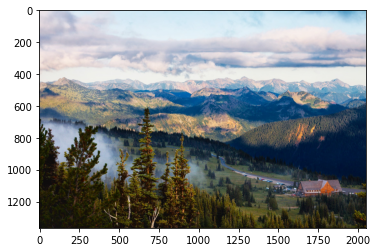

In [2]:
content_img = Image.open('rainier.jpg')
plt.imshow(content_img)

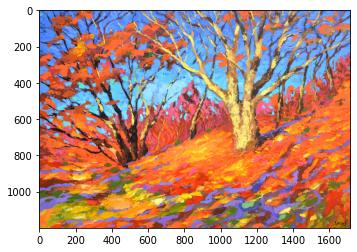

In [3]:
style_img = Image.open('autumn-oaks.jpg')
plt.imshow(style_img)

### Preprocesamiento y posprocesamiento

A continuación, definimos dos funciones para el preprocesamiento y el posprocesamiento de imágenes. La función `preprocess` estandariza cada uno de los tres canales RGB de la imagen de entrada y transforma los resultados al formato de entrada CNN. La función `postprocess` restaura los valores de píxeles en la imagen de salida a sus valores originales antes de la estandarización. Dado que la función de impresión de imágenes requiere que cada píxel tenga un valor de punto flotante de 0 a 1, reemplazamos cualquier valor menor que 0 o mayor que 1 con 0 o 1, respectivamente.


In [4]:
rgb_mean = torch.tensor([0.485, 0.456, 0.406])
rgb_std = torch.tensor([0.229, 0.224, 0.225])

def preprocess(img, image_shape):
    transforms = torchvision.transforms.Compose([
        torchvision.transforms.Resize(image_shape),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=rgb_mean, std=rgb_std)])
    return transforms(img).unsqueeze(0)

def postprocess(img):
    img = img[0].to(rgb_std.device)
    img = torch.clamp(img.permute(1, 2, 0) * rgb_std + rgb_mean, 0, 1)
    return torchvision.transforms.ToPILImage()(img.permute(2, 0, 1))

### Extracción de características

Usamos el modelo VGG-19 preentrenado en el conjunto de datos de ImageNet para extraer las características de la imagen.


In [5]:
pretrained_net = torchvision.models.vgg19(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Para extraer las características de contenido y las características de estilo de la imagen, podemos seleccionar la salida de ciertas capas en la red VGG. En términos generales, cuanto más cerca de la capa de entrada, más fácil extraer detalles de la imagen y mientras más lejos, más fácil extraer la información global de la imagen. Para evitar retener excesivamente los detalles de la imagen de contenido en la imagen sintetizada, elegimos una capa VGG que está más cerca de la salida como **capa de contenido** para generar las características de contenido de la imagen. También seleccionamos la salida de diferentes capas VGG para extraer características de estilo locales y globales. Estas capas también se denominan **capas de estilo**. 

La red VGG usa 5 bloques convolucionales. En este experimento, elegimos la última capa convolucional del cuarto bloque convolucional como la capa de contenido y la primera capa convolucional de cada bloque convolucional como la capa de estilo. Los índices de estas capas se pueden obtener imprimiendo la instancia `pretrained_net`.




In [6]:
style_layers, content_layers = [0, 5, 10, 19, 28], [25]

Al extraer características usando capas VGG, solo necesitamos usar todas aquellas desde la capa de entrada hasta la capa de contenido o la capa de estilo más cercana a la capa de salida. Construyamos una nueva red `net`, que solo conserve las capas VGG que se utilizarán para la extracción de características.


In [7]:
net = nn.Sequential(*[pretrained_net.features[i] for i in
                      range(max(content_layers + style_layers) + 1)])

Dada la entrada `X`, si simplemente invocamos la función forward `net(X)`, solo podemos obtener la salida de la última capa. Dado que también necesitamos las salidas de las capas intermedias, debemos realizar cálculos capa por capa y mantener las salidas de las capas de contenido y estilo.


In [8]:
def extract_features(X, content_layers, style_layers):
    contents = []
    styles = []
    for i in range(len(net)):
        X = net[i](X)
        if i in style_layers:
            styles.append(X)
        if i in content_layers:
            contents.append(X)
    return contents, styles

A continuación se definen dos funciones: la función `get_contents` extrae características de contenido de la imagen de contenido y la función `get_styles` extrae características de estilo de la imagen de estilo. Dado que no es necesario actualizar los parámetros del modelo VGG preentrenado durante el entrenamiento, podemos extraer el contenido y las características de estilo incluso antes de que comience el entrenamiento. Dado que la imagen sintetizada sí es un conjunto de parámetros del modelo que se actualizará para la transferencia de estilo, solo podemos extraer el contenido y las características de estilo de la imagen sintetizada llamando a la función `extract_features` durante el entrenamiento.

In [9]:
def get_contents(image_shape, device):
    content_X = preprocess(content_img, image_shape).to(device)
    contents_Y, _ = extract_features(content_X, content_layers, style_layers)
    return content_X, contents_Y

def get_styles(image_shape, device):
    style_X = preprocess(style_img, image_shape).to(device)
    _, styles_Y = extract_features(style_X, content_layers, style_layers)
    return style_X, styles_Y


### Definición de la función de pérdida

Ahora describiremos la función de pérdida para la transferencia de estilo. La función de pérdida consiste en la pérdida de contenido, la pérdida de estilo y la pérdida de variación total.



#### Pérdida de contenido

Similar a la función de pérdida en la regresión lineal, la pérdida de contenido mide la diferencia en las características de contenido entre la imagen sintetizada y la imagen de contenido a través del error cuadrático medio.

In [10]:
def content_loss(Y_hat, Y):
  # Separamos el contenido de la etiqueta del grafo computacional utilizado
  # para calcular dinámicamente el gradiente: este es un valor establecido,
  # no una variable. De lo contrario, la pérdida arrojaría un error.
  return torch.square(Y_hat - Y.detach()).mean()

#### Pérdida de estilo

La pérdida de estilo, similar a la pérdida de contenido, también utiliza el error cuadrático medio para medir la diferencia de estilo entre la imagen sintetizada y la imagen de estilo. Para expresar la salida de estilo de cualquier capa de estilo, primero usamos la función `extract_features` para calcular la salida de la capa de estilo. Suponiendo que la salida tiene 1 ejemplo, $c$ canales, altura $h$ y ancho $w$, podemos transformar esta salida en una matriz $\mathbf{X}$ con $c$ filas y $hw$ columnas. Esta matriz se puede considerar como la concatenación de $c$ vectores $\mathbf{x}_1, \ldots, \mathbf{x}_c$, cada uno de los cuales tiene una longitud de $hw$. Aquí, el vector $\mathbf{x}_i$ representa la función de estilo del canal $i$.

![Imgur](https://i.imgur.com/HCFyiLm.png)

Luego crearemos una ***matriz de Gram*** a partir de estos vectores. En esta matriz $\mathbf{X}\mathbf{X}^\top \in \mathbb{R}^{c \times c}$, el elemento $x_{ij}$ en la fila $i $ y la columna $j$ es el producto escalar de los vectores $\mathbf{x}_i$ y $\mathbf{x}_j$. Esto representa la correlación de las características de estilo de los canales $i$ y $j$. 

![Imgur](https://i.imgur.com/R7isL94.png)
Usamos esta matriz de Gram para representar la salida de estilo de cualquier capa de estilo. Tenga en cuenta que cuando el valor de $hw$ es mayor, es probable que genere valores mayores en la matriz de Gram. Tenga en cuenta también que el alto y el ancho de la matriz Gram son ambos el número de canales $c$. Para permitir que la pérdida de estilo no se vea afectada por estos valores, la siguiente función `gram` divide la matriz Gram por el número de sus elementos, es decir, $chw$.


In [11]:
def gram(X):
    num_channels, n = X.shape[1], X.numel() // X.shape[1]
    X = X.reshape((num_channels, n))
    return torch.matmul(X, X.T) / (num_channels * n)

Obviamente, las dos matrices de Gram que son entradas de la pérdida de estilo se basan en las salidas de la capa de estilo para la imagen sintetizada y la imagen de estilo. Aquí se supone que la matriz de Gram gram_Y basada en la imagen de estilo ha sido precalculada.


In [12]:
def style_loss(Y_hat, gram_Y):
    return torch.square(gram(Y_hat) - gram_Y.detach()).mean()

#### Pérdida de variación total

A veces, la imagen sintetizada aprendida tiene mucho ruido de alta frecuencia, es decir, píxeles particularmente brillantes u oscuros. Un método común de reducción de ruido es la ***eliminación de ruido de variación total***. Denote por $x_{i, j}$ el valor del píxel en la coordenada $(i, j)$. Reducir la pérdida de variación total definida como

$$\sum_{i, j} \left|x_{i, j} - x_{i+1, j}\right| + \left|x_{i, j} - x_{i, j+1}\right|$$

acerca los valores de los píxeles vecinos en la imagen sintetizada.


In [13]:
def tv_loss(Y_hat):
    return 0.5 * (torch.abs(Y_hat[:, :, 1:, :] - Y_hat[:, :, :-1, :]).mean() +
                  torch.abs(Y_hat[:, :, :, 1:] - Y_hat[:, :, :, :-1]).mean())

#### Función de pérdida

La función de pérdida de la transferencia de estilo es la suma ponderada de la pérdida de contenido, la pérdida de estilo y la pérdida de variación total. Al ajustar estos hiperparámetros de peso, podemos equilibrar la retención de contenido, la transferencia de estilo y la reducción de ruido en la imagen sintetizada.


In [14]:
content_weight, style_weight, tv_weight = 1, 1e3, 10

def compute_loss(X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram):
    contents_l = [content_loss(Y_hat, Y) * content_weight for Y_hat, Y in zip(
        contents_Y_hat, contents_Y)]
    styles_l = [style_loss(Y_hat, Y) * style_weight for Y_hat, Y in zip(
        styles_Y_hat, styles_Y_gram)]
    tv_l = tv_loss(X) * tv_weight
    l = sum(styles_l + contents_l + [tv_l])
    return contents_l, styles_l, tv_l, l

### Inicializar la imagen sintetizada

En la transferencia de estilo, la imagen sintetizada es la única variable que debe actualizarse durante el entrenamiento. Por lo tanto, podemos definir un modelo simple, SynthesizedImage, y tratar a la imagen sintetizada como los parámetros del modelo. En este modelo, la propagación directa solo devuelve los parámetros del modelo.


In [15]:
class SynthesizedImage(nn.Module):
    def __init__(self, img_shape, **kwargs):
        super(SynthesizedImage, self).__init__(**kwargs)
        self.weight = nn.Parameter(torch.rand(*img_shape))

    def forward(self):
        return self.weight

A continuación, definimos la función `get_inits`. Esta función crea una instancia de modelo de SynthesizedImage y la inicializa en la imagen `X`. Las matrices Gram para la imagen de estilo en varias capas de estilo, `styles_Y_gram`, se calculan antes del entrenamiento. 




In [16]:
def get_inits(X, device, lr, styles_Y):
    gen_img = SynthesizedImage(X.shape).to(device)
    gen_img.weight.data.copy_(X.data)
    trainer = torch.optim.Adam(gen_img.parameters(), lr=lr)
    styles_Y_gram = [gram(Y) for Y in styles_Y]
    return gen_img(), styles_Y_gram, trainer

### Entrenamiento
Al entrenar el modelo para la transferencia de estilo, extraemos continuamente características de contenido y características de estilo de la imagen sintetizada y calculamos la función de pérdida. A continuación se define el ciclo de entrenamiento.


In [32]:
#@markdown Código para animación 
from IPython import display


def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """Set the axes for matplotlib.

    Defined in :numref:`sec_calculus`"""
    axes.set_xlabel(xlabel), axes.set_ylabel(ylabel)
    axes.set_xscale(xscale), axes.set_yscale(yscale)
    axes.set_xlim(xlim),     axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()


class Animator:
    """For plotting data in animation."""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        """Defined in :numref:`sec_utils`"""
        # Incrementally plot multiple lines
        if legend is None:
            legend = []
        #use_svg_display()
        self.fig, self.axes = plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # Use a lambda function to capture arguments
        self.config_axes = lambda: set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # Add multiple data points into the figure
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [40]:
def train(X, contents_Y, styles_Y, device, lr, num_epochs, lr_decay_epoch):
    X, styles_Y_gram, trainer = get_inits(X, device, lr, styles_Y)
    scheduler = torch.optim.lr_scheduler.StepLR(trainer, lr_decay_epoch, 0.8)
    animator = Animator(xlabel='epoch', ylabel='loss',
                            xlim=[10, num_epochs],
                            legend=['content', 'style', 'TV'],
                            ncols=2, figsize=(20, 10))
    for epoch in range(num_epochs):
        trainer.zero_grad()
        contents_Y_hat, styles_Y_hat = extract_features(
            X, content_layers, style_layers)
        contents_l, styles_l, tv_l, l = compute_loss(
            X, contents_Y_hat, styles_Y_hat, contents_Y, styles_Y_gram)
        l.backward()
        trainer.step()
        scheduler.step()
        #print(epoch)
        if (epoch + 1) % 10 == 0 or epoch<5:
            animator.axes[1].imshow(postprocess(X))
            animator.add(epoch + 1, [float(sum(contents_l)),
                                     float(sum(styles_l)), float(tv_l)])
    return X

Ahora comenzamos a entrenar el modelo. Redimensionamos la altura y el ancho de las imágenes de estilo y contenido a 300 por 450 píxeles. Usamos la imagen de contenido para inicializar la imagen sintetizada.


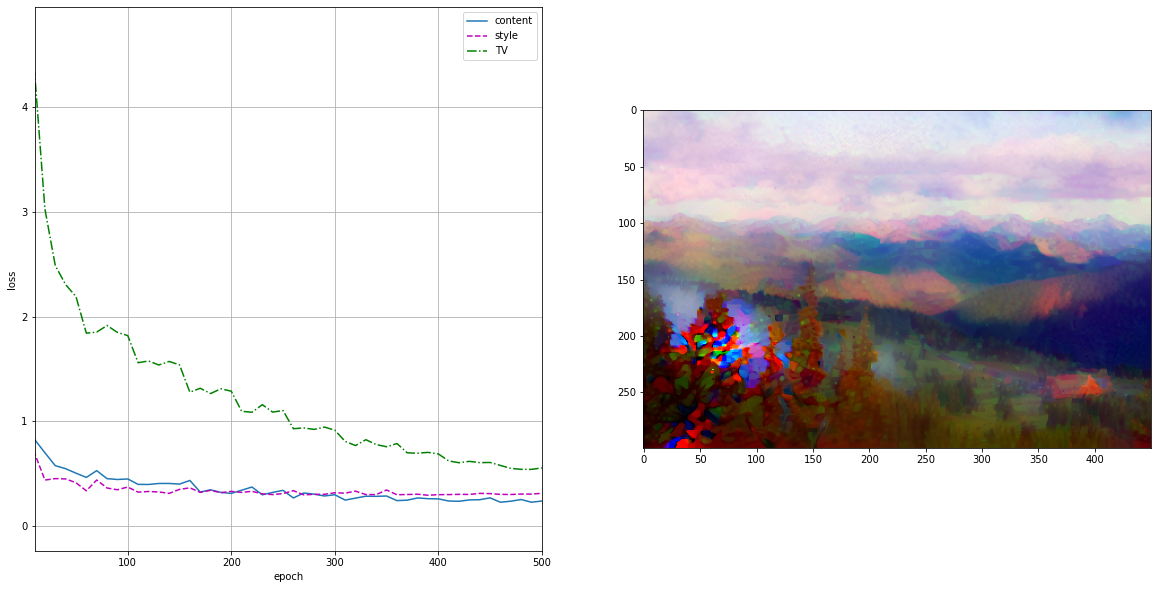

In [41]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
image_shape = (300, 450)  # PIL Image (h, w)
net = net.to(device)
content_X, contents_Y = get_contents(image_shape, device)
_, styles_Y = get_styles(image_shape, device)
output = train(content_X, contents_Y, styles_Y, device, 0.3, 500, 50)

Podemos ver que la imagen sintetizada retiene el escenario y los objetos de la imagen de contenido y transfiere el color de la imagen de estilo al mismo tiempo. Por ejemplo, la imagen sintetizada tiene bloques de color como los de la imagen de estilo. Algunos de estos bloques incluso tienen la sutil textura de las pinceladas.